In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle

In [2]:
experiment_base_dir = '/media/big-ssd/experiments'
experiment_name = 'P3856'
feature_detection_method = 'pasef'

EXPERIMENT_DIR = "{}/{}".format(experiment_base_dir, experiment_name)
IDENTIFICATIONS_DIR = '{}/identifications-{}'.format(EXPERIMENT_DIR, feature_detection_method)
IDENTIFICATIONS_FILE = '{}/exp-{}-identifications-{}.pkl'.format(IDENTIFICATIONS_DIR, experiment_name, feature_detection_method)

In [3]:
MAXIMUM_Q_VALUE = 0.01

In [8]:
with open(IDENTIFICATIONS_FILE, 'rb') as handle:
    d = pickle.load(handle)
identifications_no_correction_df = d['identifications_df']

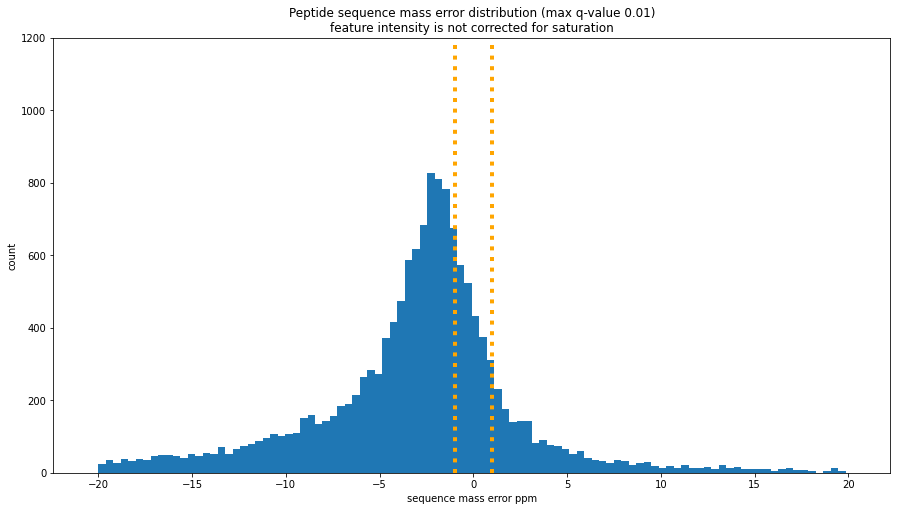

In [9]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide sequence mass error distribution (max q-value {})\nfeature intensity is not corrected for saturation'.format(MAXIMUM_Q_VALUE))

bins = 100
hist, bins, _ = plt.hist(identifications_no_correction_df.mass_accuracy_ppm, bins=bins)
plt.xlabel('sequence mass error ppm')
plt.ylabel('count')

plt.ylim((0,1200))

plt.axvline(x=+1, linestyle=':', linewidth=4, color='orange')
plt.axvline(x=-1, linestyle=':', linewidth=4, color='orange')

plt.show()

#### with correction for saturation

In [6]:
with open(IDENTIFICATIONS_FILE, 'rb') as handle:
    d = pickle.load(handle)
identifications_with_correction_df = d['identifications_df']

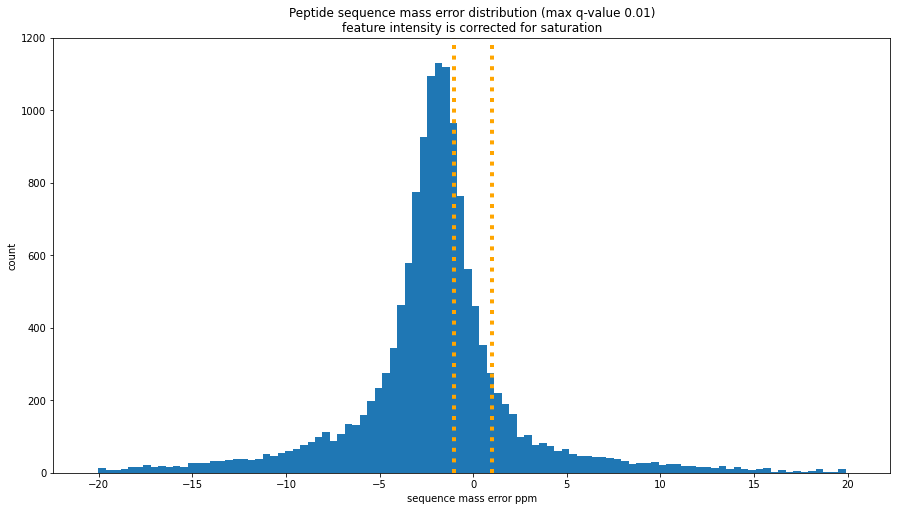

In [7]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide sequence mass error distribution (max q-value {})\nfeature intensity is corrected for saturation'.format(MAXIMUM_Q_VALUE))

bins = 100
hist, bins, _ = plt.hist(identifications_with_correction_df.mass_accuracy_ppm, bins=bins)
plt.xlabel('sequence mass error ppm')
plt.ylabel('count')

# plt.xlim((-20,20))
plt.ylim((0,1200))

plt.axvline(x=+1, linestyle=':', linewidth=4, color='orange')
plt.axvline(x=-1, linestyle=':', linewidth=4, color='orange')

plt.show()